In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset) #gives total number of batches

68

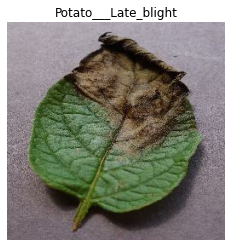

In [7]:
for image_batch, label_batch in dataset.take(1):
#     print(image_batch.shape)
#     print(label_batch.numpy())
#     print(image_batch[0].numpy())
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[0]])

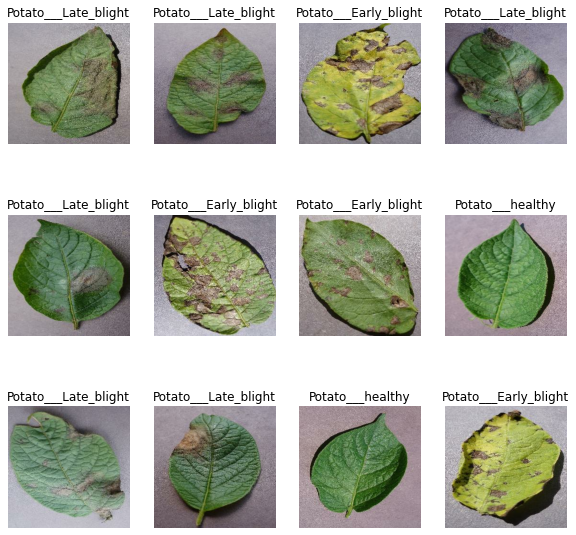

In [8]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
# read the image from the disk and for the next iteration, it will keep the image in the memory
# shuffle - shuffles the images
# prefetch - loads next set of images from the disk 
# All these will improve the performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) # letting tensorflow determine how many
# batches to load while the data in training.

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 


In [12]:
resize_and_rescale = tf.keras.Sequential(
[
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Resizes the images to 256X256
    layers.experimental.preprocessing.Rescaling(1.0/255) # Rescales from (0-255) in RGB in numpy to (0-1)
]
)

In [13]:
# Data Augmentation: Generate new training samples by manipulating the existing training samples
# Manipulating here means, rescaling, rotation, translation, yada yada

data_augmentation = tf.keras.Sequential(
[
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
]
)

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [19]:
model.fit(
    train_ds, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 33s 598ms/step - loss: 0.9072 - accuracy: 0.4612 - val_loss: 0.9434 - val_accuracy: 0.4167
Epoch 2/50
54/54 [==============================] - 35s 648ms/step - loss: 0.7668 - accuracy: 0.5880 - val_loss: 0.5804 - val_accuracy: 0.7396
Epoch 3/50
54/54 [==============================] - 35s 656ms/step - loss: 0.5383 - accuracy: 0.7575 - val_loss: 0.3393 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 36s 677ms/step - loss: 0.3688 - accuracy: 0.8501 - val_loss: 0.2775 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 31s 572ms/step - loss: 0.3229 - accuracy: 0.8686 - val_loss: 0.2202 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 31s 567ms/step - loss: 0.2470 - accuracy: 0.9074 - val_loss: 0.1802 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 35s 654ms/step - loss: 0.1794 - accuracy: 0.9259 - val_loss: 0.1472 - val_accuracy: 0.9583

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 165ms/step
Predicted label: Potato___Late_blight


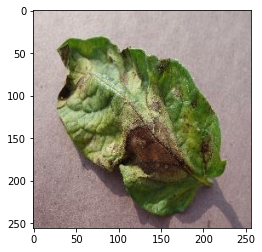

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])